Author: Adam Chebil https://github.com/AdamMC-GL

In [1]:
# Data analysis:
import pandas as pd
import csv
import numpy as np
import scipy.stats as stats
import pickle

# Visualisation:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

# Scores:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder

# Introduction

Dit onderzoek wordt gedaan in opdracht van ProRail met als doel het in kaart brengen van de huidige situatie omtrent storingen en het opstarten van het treinverkeer na een storing.
Er wordt hierbij uitgebreid analyse gedaan naar de data waarnaar er modellen worden opgezet die dit visueel ondersteunen. Dit model zal een voorspelling geven van de duur van de herstelperiode na een storing.

Hiernaast zal er ook gekeken worden naar een hypothese, 'is de prognose van de aannemer te behoudend?' is de onderzoeksvraag van deze hypothese. De hypothese is 'De aannemer is te conservatief in zijn analyse over de hersteltijd.'


In [2]:
imp_feat = ['stm_geo_mld', 'stm_prioriteit', 'stm_oorz_code', 'stm_progfh_in_duur', 
            "stm_progfh_gw_teller", 'stm_sap_meldtijd', "stm_fh_duur", "stm_progfh_gw_teller", 
       "stm_afspr_aanvangdd", "stm_afspr_func_hersteldd", "stm_afspr_aanvangtijd", 
       "stm_progfh_gw_duur", "stm_oorz_groep", "stm_geo_mld_uit_functiepl"]

In [3]:
df_org = pd.read_csv('C:/Users/adam/OneDrive/Documenten/sap_storing_data_hu_project.csv', usecols= imp_feat, encoding='UTF-8')
df_org


Columns (11,82,87) have mixed types.Specify dtype option on import or set low_memory=False.


,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_sap_meldtijd,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,624.0,624.0,9.0,ONR-RIB,133.0,09:00:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,0.0,00/00/0000
2,201.0,201.0,9.0,ONR-DERD,143.0,12:35:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,51.0,00/00/0000
3,25.0,25.0,9.0,ONR-DERD,142.0,16:40:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,40.0,00/00/0000
4,12.0,12.0,9.0,ONR-DERD,142.0,22:30:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,6.0,00/00/0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865468,553,553.0,2.0,ONR-DERD,151.0,19:17:12,0,0.0,0.0,00/00/0000,00:00:00,163.0,00/00/0000
865469,553,553.0,2.0,ONR-DERD,151.0,19:17:12,0,0.0,0.0,00/00/0000,00:00:00,163.0,00/00/0000
865470,54,54.0,2.0,WEER,181.0,23:33:17,79415,0.0,2.0,00/00/0000,00:00:00,155.0,00/00/0000
865471,155,155.0,9.0,NaN,NaN,23:44:32,0,0.0,0.0,00/00/0000,00:00:00,5.0,00/00/0000


# Data cleaning

Eerst beginnen we met het opschonen van de raw data, deze data kan moeilijk geanalyseerd worden als er nog veel fouten in zit. Er is al eerder gekeken naar welke kolommen van toepassing zijn, daarom worden deze direct ingeladen.

We kijken eerst naar welke kolommen te veel missende data bevat, we zullen dan zo een kolom niet meer gebruiken. Hierna zullen we alle duplicaties verwijderen in de rijen. Daarna zullen we alle rijen verwijderen die kolommen bevatten die geen waardes hebben. Daarbij zullen we ook alle nominale kolommen in bruikbare ordinale kolommen omzetten.

In [4]:
dropped_columns = []
for i in df_org.columns:
    if df_org[i].isna().sum() > 100000:
        dropped_columns.append(i)
df_nan = df_org.drop(columns=dropped_columns)
df_nan

,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_sap_meldtijd,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,624.0,624.0,9.0,ONR-RIB,133.0,09:00:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,0.0,00/00/0000
2,201.0,201.0,9.0,ONR-DERD,143.0,12:35:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,51.0,00/00/0000
3,25.0,25.0,9.0,ONR-DERD,142.0,16:40:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,40.0,00/00/0000
4,12.0,12.0,9.0,ONR-DERD,142.0,22:30:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,6.0,00/00/0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865468,553,553.0,2.0,ONR-DERD,151.0,19:17:12,0,0.0,0.0,00/00/0000,00:00:00,163.0,00/00/0000
865469,553,553.0,2.0,ONR-DERD,151.0,19:17:12,0,0.0,0.0,00/00/0000,00:00:00,163.0,00/00/0000
865470,54,54.0,2.0,WEER,181.0,23:33:17,79415,0.0,2.0,00/00/0000,00:00:00,155.0,00/00/0000
865471,155,155.0,9.0,NaN,NaN,23:44:32,0,0.0,0.0,00/00/0000,00:00:00,5.0,00/00/0000


In [5]:
# De dubbele waardes worden verwijderd
df_nan.drop_duplicates(inplace=True)
df_nan

,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_sap_meldtijd,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,624.0,624.0,9.0,ONR-RIB,133.0,09:00:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,0.0,00/00/0000
2,201.0,201.0,9.0,ONR-DERD,143.0,12:35:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,51.0,00/00/0000
3,25.0,25.0,9.0,ONR-DERD,142.0,16:40:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,40.0,00/00/0000
4,12.0,12.0,9.0,ONR-DERD,142.0,22:30:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,6.0,00/00/0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865465,553,553.0,5.0,ONR-DERD,151.0,22:18:55,582,0.0,1.0,12/04/2018,02:00:01,521.0,12/04/2018
865467,553,553.0,2.0,ONR-DERD,151.0,19:17:12,0,0.0,0.0,00/00/0000,00:00:00,163.0,00/00/0000
865470,54,54.0,2.0,WEER,181.0,23:33:17,79415,0.0,2.0,00/00/0000,00:00:00,155.0,00/00/0000
865471,155,155.0,9.0,NaN,NaN,23:44:32,0,0.0,0.0,00/00/0000,00:00:00,5.0,00/00/0000


In [19]:
"Verwijder NaN values"
df = df_nan.dropna()
df['stm_progfh_in_duur'] = pd.to_numeric(df['stm_progfh_in_duur'], errors='coerce')
df = df.dropna()     
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_sap_meldtijd,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd
1,624.0,624.0,9.0,ONR-RIB,133.0,09:00:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,0.0,00/00/0000
2,201.0,201.0,9.0,ONR-DERD,143.0,12:35:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,51.0,00/00/0000
3,25.0,25.0,9.0,ONR-DERD,142.0,16:40:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,40.0,00/00/0000
4,12.0,12.0,9.0,ONR-DERD,142.0,22:30:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,6.0,00/00/0000
5,614.0,614.0,9.0,TECHONV,218.0,11:23:00,99999999.0,99999999.0,0.0,00/00/0000,00:00:00,7.0,00/00/0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865461,564,564.0,5.0,ONR-DERD,151.0,16:13:42,0.0,0.0,0.0,12/04/2018,13:00:00,1250.0,12/04/2018
865462,54,54.0,5.0,TECHONV,298.0,17:08:02,52.0,0.0,1.0,11/04/2018,17:08:02,15.0,14/04/2018
865465,553,553.0,5.0,ONR-DERD,151.0,22:18:55,582.0,0.0,1.0,12/04/2018,02:00:01,521.0,12/04/2018
865467,553,553.0,2.0,ONR-DERD,151.0,19:17:12,0.0,0.0,0.0,00/00/0000,00:00:00,163.0,00/00/0000


In [20]:
"Zet kolommen om in ordinale variablen"
df["stm_progfh_in_duur"] = df["stm_progfh_in_duur"]+80
for i in df.columns:
    if df[i].dtype == object and i != "stm_sap_meldtijd":
        codes, uniques = pd.factorize(df[i])
        df[i] = codes
df

,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_sap_meldtijd,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd
1,0,624.0,9.0,0,133.0,09:00:00,100000079.0,0,0.0,0,0,0.0,0
2,1,201.0,9.0,1,143.0,12:35:00,100000079.0,0,0.0,0,0,51.0,0
3,2,25.0,9.0,1,142.0,16:40:00,100000079.0,0,0.0,0,0,40.0,0
4,3,12.0,9.0,1,142.0,22:30:00,100000079.0,0,0.0,0,0,6.0,0
5,4,614.0,9.0,2,218.0,11:23:00,100000079.0,0,0.0,0,0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865461,116,564.0,5.0,1,151.0,16:13:42,80.0,2,0.0,707,61,1250.0,710
865462,31,54.0,5.0,2,298.0,17:08:02,132.0,2,1.0,705,14944,15.0,709
865465,54,553.0,5.0,1,151.0,22:18:55,662.0,2,1.0,707,259,521.0,710
865467,54,553.0,2.0,1,151.0,19:17:12,80.0,2,0.0,0,0,163.0,0


In [21]:
print(len(df['stm_geo_mld']))
df['stm_geo_mld'] = pd.to_numeric(df['stm_geo_mld'], errors='coerce')
df = df.dropna()
print(len(df['stm_geo_mld']))

591705
591705


# Data understanding

We zullen nu beginnen met wat analyse van de date. Hieronder is te zien welke waardes van de target variable het vaakst voorkomen, dit geeft een beter inzicht over welke waardes we het vaakst kunnen verwachten. Daarnaast zullen we ook een correlatie verhouding opzetten van de features en target. We zullen dit ook na het verfijnen van de data doen.

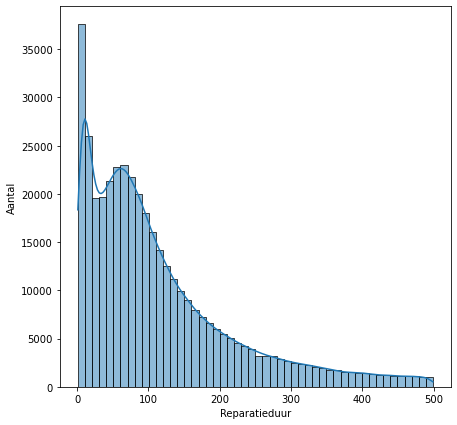

In [9]:

plt.figure(figsize=(7,7))
plt.xlabel('Reparatieduur')
plt.ylabel('Aantal')

fig = sns.histplot(data=df[(df['stm_fh_duur']< 500) & (df['stm_fh_duur'] > 0)]['stm_fh_duur'],kde=True, bins=50)


In [10]:
# Meet hoeveel correlatie er is tussen de target variable en elke feature variable
df.corr()['stm_fh_duur'].sort_values()[-10:]

stm_afspr_func_hersteldd     0.007083
stm_oorz_groep               0.011214
stm_afspr_aanvangtijd        0.015377
stm_afspr_aanvangdd          0.015661
stm_progfh_gw_teller         0.020835
stm_geo_mld_uit_functiepl    0.022004
stm_oorz_code                0.025942
stm_geo_mld                  0.026279
stm_progfh_gw_duur           0.029368
stm_fh_duur                  1.000000
Name: stm_fh_duur, dtype: float64

# Data understanding hypothese

Hiernaast hebben we ook wat analyse over de hypothese. We zien in de onderstaande grafieken dat het gemiddelde verschil tussen de prognose en actuele hersteltijd altijd boven de 0 is, dat de behoudend is voor de prognose. De grafiek laat zien dat dit bij elk afsnijding van de outliers is.

Daarnaast zien we dat het relatieve verschil gemiddeld 200% is bij elke afsnijding.

Hierna zijn er ook wat plotten gegeven over wat samples van de data, die ook op een oog opslag laten zien dat de prognose vaak te laag is. Een blauwe balk betekent dat de prognose lager was dan de actuele herstel tijd.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


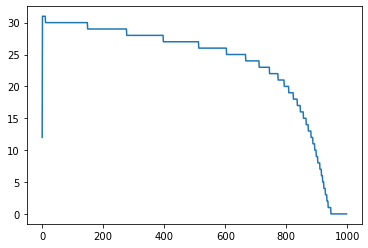

In [11]:
df = df_org.dropna()
df['stm_progfh_in_duur'] = pd.to_numeric(df['stm_progfh_in_duur'], errors='coerce')
df = df.dropna()

meds = []
for i in range(1, 999):
    print(i, end="\r")
    diff = (df['stm_fh_duur'] - df['stm_progfh_in_duur'])
    meds.append(diff.median())
    df = df[df['stm_progfh_in_duur'] < 999 - i]
    df = df[df['stm_fh_duur'] < 999 - i]
    
plt.plot(meds)
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


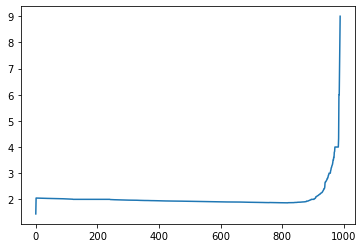

In [12]:
df = df_org.dropna()
df['stm_progfh_in_duur'] = pd.to_numeric(df['stm_progfh_in_duur'], errors='coerce')
df = df.dropna()

meds = []
for i in range(1, 999):
    print(i, end="\r")
    diff = (df['stm_fh_duur'] / df['stm_progfh_in_duur'])
    meds.append(diff.median())
    
    df = df[df['stm_progfh_in_duur'] < 999 - i]
    df = df[df['stm_fh_duur'] < 999 - i]
    
plt.plot(meds)
plt.show()

38.0
449.0
59.47100988957967


<BarContainer object of 1000 artists>

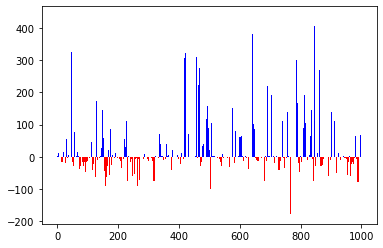

In [27]:
diff = (df['stm_fh_duur'] - df['stm_progfh_in_duur'])
print(diff.median())
print(diff.max())
print(sum(diff) / len(diff))


rs = 7384 + 100
fig = plt.figure()
ax = plt.subplot(111)
mask1 = np.array(diff[rs:rs + 1000])*np.array(diff[rs:rs + 1000] < 0)
mask2 = np.array(diff[rs:rs + 1000])*np.array(diff[rs:rs + 1000] >= 0)

ax.bar(range(len(mask1)), mask1, width=1, color='r')
ax.bar(range(len(mask2)), mask2, width=1, color='b')


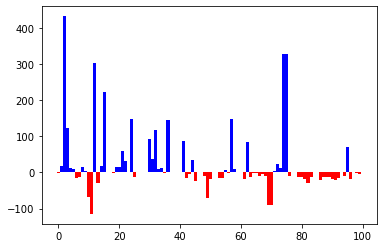

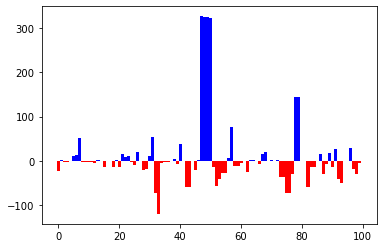

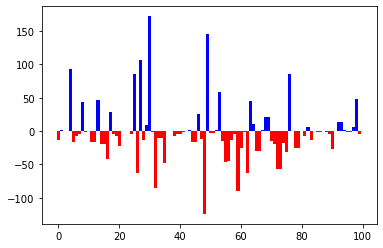

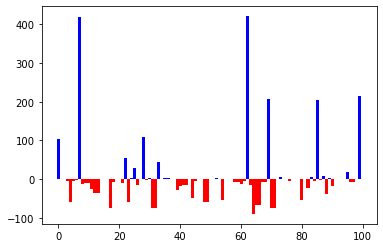

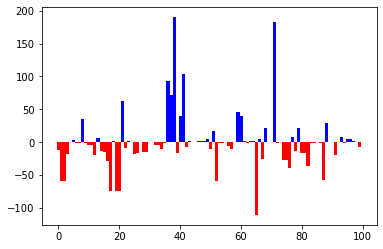

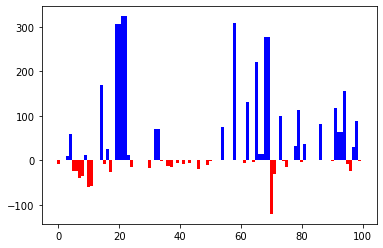

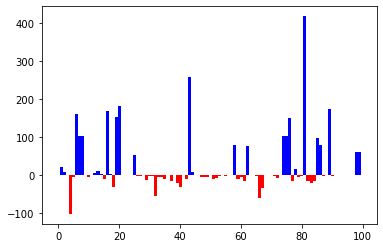

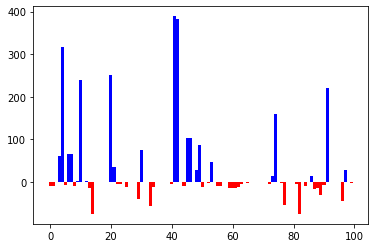

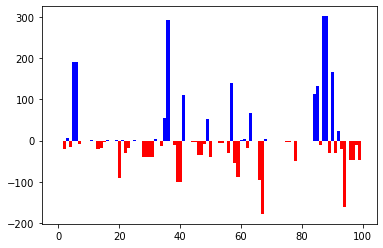

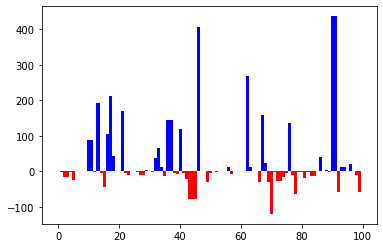

In [28]:
diff = (df['stm_fh_duur'] - df['stm_progfh_in_duur'])
for i in range(10):
    rs = 7384 + i*100
    fig = plt.figure()
    ax = plt.subplot(111)
    mask1 = np.array(diff[rs:rs + 100])*np.array(diff[rs:rs + 100] < 0)
    mask2 = np.array(diff[rs:rs + 100])*np.array(diff[rs:rs + 100] >= 0)

    ax.bar(range(len(mask1)), mask1, width=1, color='r')
    ax.bar(range(len(mask2)), mask2, width=1, color='b')

# Data preperation

Hier zullen we de data klaar maken om te kunnen gebruiken. We beginnen met het verwijderen van outliers, waarbij we de standaard IQR methode gebruiken. Daarbij zetten we ook de meldtijd om in gecategorizeerde boolean variablen. Waar de meldtijd veranderd in een dag sectie. Na het normalizeren van de data kijken we nogmaals naar de correlatie matrix (deze correlatie matrix gaat niet over de genormalizeerde data)

In [24]:
# remove 0 values
df = df[df['stm_progfh_in_duur'] > 0 ]
df = df[df['stm_fh_duur'] > 0 ]

df = df[df['stm_progfh_in_duur'] < 999 ]
df = df[df['stm_fh_duur'] < 999 ]

outlier_range = 1.5

q1=df['stm_fh_duur'].quantile(0.25)
q3=df['stm_fh_duur'].quantile(0.75)
IQR=q3-q1

df = df[~((df['stm_fh_duur']<(q1-outlier_range*IQR)) | (df['stm_fh_duur']>(q3+outlier_range*IQR)))]

# stm_progfh_in_duur
q1=df['stm_progfh_in_duur'].quantile(0.25)
q3=df['stm_progfh_in_duur'].quantile(0.75)
IQR=q3-q1

df = df[~((df['stm_progfh_in_duur']<(q1-outlier_range*IQR)) | (df['stm_progfh_in_duur']>(q3+outlier_range*IQR)))]


df

,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_sap_meldtijd,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd
32099,70,104.0,9.0,2,299.0,20:50:00,120.0,0,0.0,0,0,43.0,0
52800,87,38.0,9.0,0,131.0,07:00:00,80.0,0,0.0,0,0,15.0,1
84560,47,23.0,9.0,2,299.0,18:48:00,80.0,0,0.0,0,0,7.0,0
86470,35,586.0,9.0,0,133.0,15:58:53,80.0,0,0.0,0,0,232.0,0
86879,55,119.0,9.0,0,133.0,12:37:33,80.0,0,0.0,0,0,8.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865444,170,70.0,5.0,1,146.0,13:42:19,98.0,2,1.0,705,625,18.0,708
865451,123,98.0,5.0,2,227.0,14:55:23,89.0,2,1.0,707,212,10.0,710
865455,73,120.0,5.0,2,223.0,16:15:47,214.0,2,1.0,705,13057,120.0,708
865462,31,54.0,5.0,2,298.0,17:08:02,132.0,2,1.0,705,14944,15.0,709


In [25]:
condition_ochtend_spits = (df['stm_sap_meldtijd'] >= '06:30:00') & (df['stm_sap_meldtijd'] <= '09:00:00')
df['spits_ochtend'] = np.where(condition_ochtend_spits, 1, 0) 

condition_avond_spits = (df['stm_sap_meldtijd'] >= '16:00:00') & (df['stm_sap_meldtijd'] <= '18:30:00')
df['spits_avond'] = np.where(condition_avond_spits, 1, 0) 

condition_nacht = (df['stm_sap_meldtijd'] <= '06:30:00') | (df['stm_sap_meldtijd'] >= '22:00:00')
df['nacht'] = np.where(condition_nacht, 1, 0)

condition_overdag = (df['stm_sap_meldtijd'] >= '09:00:00') & (df['stm_sap_meldtijd'] <= '16:00:00')
df['overdag'] = np.where(condition_avond_spits, 1, 0) 

condition_overig1 = (df['stm_sap_meldtijd'] >= '18:30:00') & (df['stm_sap_meldtijd'] <= '22:00:00')
df['avond'] = np.where(condition_avond_spits, 1, 0) 
df = df.drop(columns=['stm_sap_meldtijd'])
df

,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd,spits_ochtend,spits_avond,nacht,overdag,avond
32099,70,104.0,9.0,2,299.0,120.0,0,0.0,0,0,43.0,0,0,0,0,0,0
52800,87,38.0,9.0,0,131.0,80.0,0,0.0,0,0,15.0,1,1,0,0,0,0
84560,47,23.0,9.0,2,299.0,80.0,0,0.0,0,0,7.0,0,0,0,0,0,0
86470,35,586.0,9.0,0,133.0,80.0,0,0.0,0,0,232.0,0,0,0,0,0,0
86879,55,119.0,9.0,0,133.0,80.0,0,0.0,0,0,8.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865444,170,70.0,5.0,1,146.0,98.0,2,1.0,705,625,18.0,708,0,0,0,0,0
865451,123,98.0,5.0,2,227.0,89.0,2,1.0,707,212,10.0,710,0,0,0,0,0
865455,73,120.0,5.0,2,223.0,214.0,2,1.0,705,13057,120.0,708,0,1,0,1,1
865462,31,54.0,5.0,2,298.0,132.0,2,1.0,705,14944,15.0,709,0,1,0,1,1


In [29]:

names = df.columns
df = df.reset_index(drop=True)
d = preprocessing.Normalizer().fit(df)
scaled_df = d.transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

scaled_df

,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_prioriteit,stm_oorz_groep,stm_oorz_code,stm_progfh_in_duur,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_duur,stm_afspr_func_hersteldd,spits_ochtend,spits_avond,nacht,overdag,avond
0,0.212364,0.315512,0.027304,0.006068,0.907098,0.121351,0.000000,0.000000,0.000000,0.000000,0.130452,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.534618,0.233511,0.055305,0.000000,0.805000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092176,0.006145,0.006145,0.000000,0.0,0.000000,0.000000
2,0.154725,0.075716,0.029628,0.006584,0.984314,0.000000,0.000000,0.000000,0.000000,0.000000,0.023044,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.054251,0.908320,0.013950,0.000000,0.206154,0.000000,0.000000,0.000000,0.000000,0.000000,0.359608,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.293903,0.635900,0.048093,0.000000,0.710712,0.000000,0.000000,0.000000,0.000000,0.000000,0.042750,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288076,0.141436,0.058238,0.004160,0.000832,0.121468,0.014976,0.001664,0.000832,0.586542,0.519984,0.014976,0.589038,0.000000,0.000000,0.0,0.000000,0.000000
288077,0.115946,0.092380,0.004713,0.001885,0.213982,0.008484,0.001885,0.000943,0.666456,0.199843,0.009427,0.669284,0.000000,0.000000,0.0,0.000000,0.000000
288078,0.005573,0.009161,0.000382,0.000153,0.017024,0.010230,0.000153,0.000076,0.053821,0.996789,0.009161,0.054050,0.000000,0.000076,0.0,0.000076,0.000076
288079,0.002069,0.003605,0.000334,0.000134,0.019892,0.003471,0.000134,0.000067,0.047061,0.997557,0.001001,0.047328,0.000000,0.000067,0.0,0.000067,0.000067


In [30]:
print(df['stm_fh_duur'].max())
print(df['stm_progfh_in_duur'].max())


449.0
202.0


In [31]:
# Meet hoeveel correlatie er is tussen de target variable en elke feature variable
df.corr()['stm_fh_duur'].sort_values()[-10:]

stm_afspr_aanvangtijd       0.033157
stm_progfh_gw_teller        0.044423
stm_progfh_gw_duur          0.060061
spits_ochtend               0.074600
nacht                       0.077281
stm_afspr_aanvangdd         0.119666
stm_afspr_func_hersteldd    0.146690
stm_prioriteit              0.234409
stm_progfh_in_duur          0.380649
stm_fh_duur                 1.000000
Name: stm_fh_duur, dtype: float64

# Baseline

Hieronder zullen verschillende baselines vertoond worden. Onderandere de baseline van de mediaan aanhouden, het gemiddelde aanhoude, en de prognose aanhouden.

In [32]:

average = sum(df['stm_fh_duur']) / len(df['stm_fh_duur'])
baseline = [average] * len(df['stm_fh_duur'])
np.sqrt(mean_squared_error(df['stm_fh_duur'], baseline))

89.04494437214763

In [33]:
median = df['stm_fh_duur'].median()
baseline = [median] * len(df['stm_fh_duur'])
np.sqrt(mean_squared_error(df['stm_fh_duur'], baseline))

91.9463994414305

In [34]:
print(np.sqrt(mean_squared_error(df['stm_fh_duur'], df['stm_progfh_in_duur'])))


102.33361204460414


# model

We zullen nu het model maken. De gekozen features zijn de top 6 features met de hoogste correlatie.

In [61]:
"""Seperate the dataset into its label (y) and input data (X)"""
X = scaled_df[['stm_prioriteit', 'stm_progfh_in_duur', "nacht",
       "stm_afspr_aanvangdd", "stm_afspr_func_hersteldd", "spits_ochtend"]].values

y = df['stm_fh_duur'].values
print("Labels:\n {} \n".format(y))
print("Training data: \n {} \n".format(X))


Labels:
 [ 43.  15.   7. ... 120.  15. 163.] 

Training data: 
 [[0.02730396 0.12135094 0.         0.         0.         0.        ]
 [0.05530535 0.         0.         0.         0.00614504 0.00614504]
 [0.02962819 0.         0.         0.         0.         0.        ]
 ...
 [0.00038171 0.01022974 0.         0.05382065 0.05404968 0.        ]
 [0.00033376 0.00347116 0.         0.04706085 0.04732787 0.        ]
 [0.00334215 0.         0.         0.         0.         0.        ]] 



In [62]:
"""Split the data into train and test data, the test data is 20% of the entire dataset."""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  random_state=3)
print("Size of test dataset: {}".format(len(X_test)))
print("Size of train dataset: {}".format(len(X_train)))

Size of test dataset: 57617
Size of train dataset: 230464


In [63]:
# Instance and fit 
model = DecisionTreeRegressor(max_depth=12)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print("Score of the model: {}".format(score))
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

Score of the model: 0.31022479759174715


73.48698345220848

Text(0, 0.5, 'Scores')

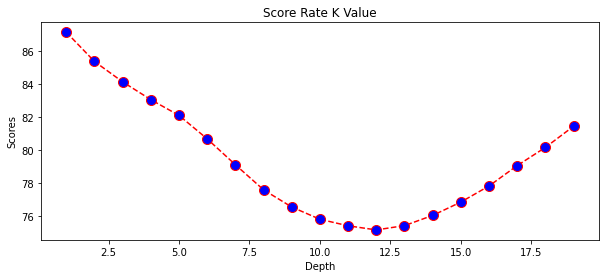

In [50]:


"""Plot effect ot the accuracy based on the K value"""
scores = []
# Calculating error for K values between 1 and 20
for i in range(1, 20):
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    scores.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print("Current Depth calculating: {}".format(i), end="\r")  # \r to flush output

# plot score figure
plt.figure(figsize=(10, 4))
plt.plot(range(1, 20), scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Score Rate K Value')
plt.xlabel('Depth')
plt.ylabel('Scores')



In [ ]:
# Predictions
preds = model.predict(X_test)

# Performance
performance = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': preds,
                            'Error': preds - y_test})

# View
print("Amount precisely 0.0 error:", len(performance[performance["Error"] == 0]))

performance


# conclusie

Vanuit de analyse over de hypothese is duidelijk te concluderen dat de prognose te conservatief is in zijn uitslag. Daarbij is ook aan te tonen dat een model betere resultaten kan opleveren dan het aanhouden van een mediaan. Er is ook duidelijk een correlatie te vinden in de hersteltijd van een probleem, en de kwaliteiten van een probleem.